# FIN3080 Assignment 3

> **Author Information**:
>- Name: `Weiyuan Xu`
>- StdID: `120090888`

## 0. Preparations

### 0-1. Load in packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
import statsmodels.api as sm

from mpl_toolkits.mplot3d import Axes3D

### 0-2. Load in datasets

#### 0-2-1. Read datasets

> **Data Resources**:
>- Data Service Platform: `CSMAR`
>- Databases: `CSMAR_China Stock Market Series` & `CSMAR_China Listed Firms Research Series`

**Detailed Selection Process of Data Tables Used:**
- table_one: China Stock Market Series -> Stock Trading -> Individual Stock Trading -> Monthly Stock Price & Returns
- table_two: China Listed Firms Research Series -> Financial Indicators -> Earning Capacity

***Note: All above tables only include the information of A-shares with the filtering function of CSMAR***

In [2]:
table_one = pd.read_csv('1.csv')
table_two = pd.read_csv('2.csv')

#### 0-2-2. Preliminary processing and interpret for individual datasets

**Variables in Table 1:**
- Monthly Closing Price
- Monthly Return
- Market Type

**Interpretation of picking corresponding tickers:**
- Monthly Closing Price: Use ***Monthly Closing Price*** since these two concepts are equivalent.
- Monthly Return: Use ***Monthly Return with Cash Dividend Reinvested***.
- Market Type: Use ***Monthly Type*** to classify different markets.

In [3]:
table_one = table_one.rename(columns={"Stkcd": "Stock_Code", "Trdmnt": "Date", "Mretwd": "Monthly_Return", "Markettype": "Market_Type", "Mclsprc" : "Monthly_ClosingPrice"})
table_one.head()

,Stock_Code,Date,Monthly_ClosingPrice,Monthly_Return,Market_Type
0,1,2011-12,15.59,0.005158,4
1,1,2012-01,16.64,0.067351,4
2,1,2012-02,17.10,0.027644,4
3,1,2012-03,15.71,-0.081287,4
4,1,2012-04,16.56,0.054106,4


***Market Type Extraction***
- Main Board: ***Market Type*** = 1, 4, 64

In [4]:
table_one = table_one.loc[table_one["Market_Type"].isin([1, 4, 64])]
table_one = table_one.loc[:,["Stock_Code", "Date", "Monthly_ClosingPrice", "Monthly_Return"]]
table_one.head()

,Stock_Code,Date,Monthly_ClosingPrice,Monthly_Return
0,1,2011-12,15.59,0.005158
1,1,2012-01,16.64,0.067351
2,1,2012-02,17.10,0.027644
3,1,2012-03,15.71,-0.081287
4,1,2012-04,16.56,0.054106


**Variable in Table 2:**
- Quarterly Return on Equity (ROE)

**Interpretation of picking corresponding ticker:**
- Return on Equity (ROE): Use ***Return on Equity - TTM*** since TTM-version ROE provides a more up-to-date picture of a company's ROE.

***Remarks:*** 

When accessing data from CSMAR, we set the condition **"Statement Type = Consolidated Statements"** since:

Consolidated statements reflect the financial position and operating results of the entire enterprise group; 
The parent statement only reflects the business situation of the parent company, and its right to control the entire enterprise group is actually reflected in the long-term asset account as an investment. 
In the process of merging the statements of the parent company and the subsidiary company, the parent company's investment in the subsidiary company, internal purchase and sale, creditor's rights and debts are offset.

In [5]:
table_two = table_two.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "F050504C": "ROE"})
table_two = table_two.loc[:,["Stock_Code", "Date", "ROE"]]
table_two.head()

,Stock_Code,Date,ROE
0,1,2011-09-30,0.179041
1,1,2011-12-31,0.191392
2,1,2012-03-31,0.199879
3,1,2012-06-30,0.212389
4,1,2012-09-30,0.169366


## Problem 1

### 1-1. Problem 1-1: Construct ten portfolios

### 1-1-1. Construct records of Return and last-month Return

In [6]:
df_1 = table_one.loc[:,["Stock_Code", "Date", "Monthly_Return"]]
df_1['Date'] = pd.to_datetime(df_1['Date']).dt.to_period('M')
df_1['last_Monthly_Return'] = df_1.groupby(["Stock_Code"])['Monthly_Return'].shift()
df_1 = df_1.loc[(df_1['Date'] >= '2012-01') & (df_1['Date'] <= '2022-12')]
df_1.head()

,Stock_Code,Date,Monthly_Return,last_Monthly_Return
1,1,2012-01,0.067351,0.005158
2,1,2012-02,0.027644,0.067351
3,1,2012-03,-0.081287,0.027644
4,1,2012-04,0.054106,-0.081287
5,1,2012-05,-0.052536,0.054106


In [7]:
df_1.describe()

,Stock_Code,Monthly_Return,last_Monthly_Return
count,335046.000000,333645.000000,332220.000000
mean,301739.347752,0.011998,0.011499
std,301701.629898,0.155514,0.156006
min,1.000000,-0.882166,-0.850649
25%,2193.000000,-0.067174,-0.067797
50%,3016.000000,-0.001956,-0.001972
75%,600773.000000,0.072165,0.072188
max,873527.000000,12.848213,12.848213


### 1-1-2. Construct monthly portfolios

In [ ]:
portfolios_curr = pd.DataFrame()

for monthYear in pd.period_range('2012-01', '2022-12', freq = 'M'):
    data_currMY = df_1.loc[df_1['Date'] == monthYear]

    data_currMY = data_currMY.sort_values('last_Monthly_Return')
    
    data_currMY['group'] = pd.qcut(data_currMY['last_Monthly_Return'], 10, labels = False)
    
    group_curr_returns = data_currMY.groupby('group')['Monthly_Return'].mean()
    
    portfolios_curr[monthYear] = group_curr_returns

portfolios_curr = portfolios_curr.T

melted = pd.melt(portfolios_curr.reset_index(), id_vars = ['index'], value_vars = list(portfolios_curr.columns), var_name = 'group', value_name = 'Monthly_Return')
melted.columns = ['Date', 'Group', 'Monthly_Return']
melted = melted.sort_values(['Group','Date'])
melted["Group"] = melted["Group"] + 1
melted['Group'] = melted['Group'].astype(int)
melted["temp"] = melted["Monthly_Return"] + 1
melted["Cum Return"] = melted.groupby("Group")["temp"].cumprod() - 1

In [9]:
melted.head()

,Date,Group,Monthly_Return,temp,Cum Return
0,2012-01,1,0.051419,1.051419,0.051419
1,2012-02,1,0.162313,1.162313,0.222078
2,2012-03,1,-0.060310,0.939690,0.148374
3,2012-04,1,0.084524,1.084524,0.245439
4,2012-05,1,0.018335,1.018335,0.268275


In [10]:
melted.describe()

,Group,Monthly_Return,temp,Cum Return
count,1320.00000,1320.000000,1320.000000,1320.000000
mean,5.50000,0.012217,1.012217,1.636629
std,2.87337,0.082223,0.082223,1.425604
min,1.00000,-0.332986,0.667014,-0.639999
25%,3.00000,-0.030571,0.969429,0.280478
50%,5.50000,0.007628,1.007628,1.506837
75%,8.00000,0.052395,1.052395,2.797731
max,10.00000,0.320461,1.320461,5.639390


### 1-2. Problem 1-2: Do plotting from Jan. 2012 to Dec. 2022

#### 1-2-1. Plot a bar chart for average monthly portfolios returns

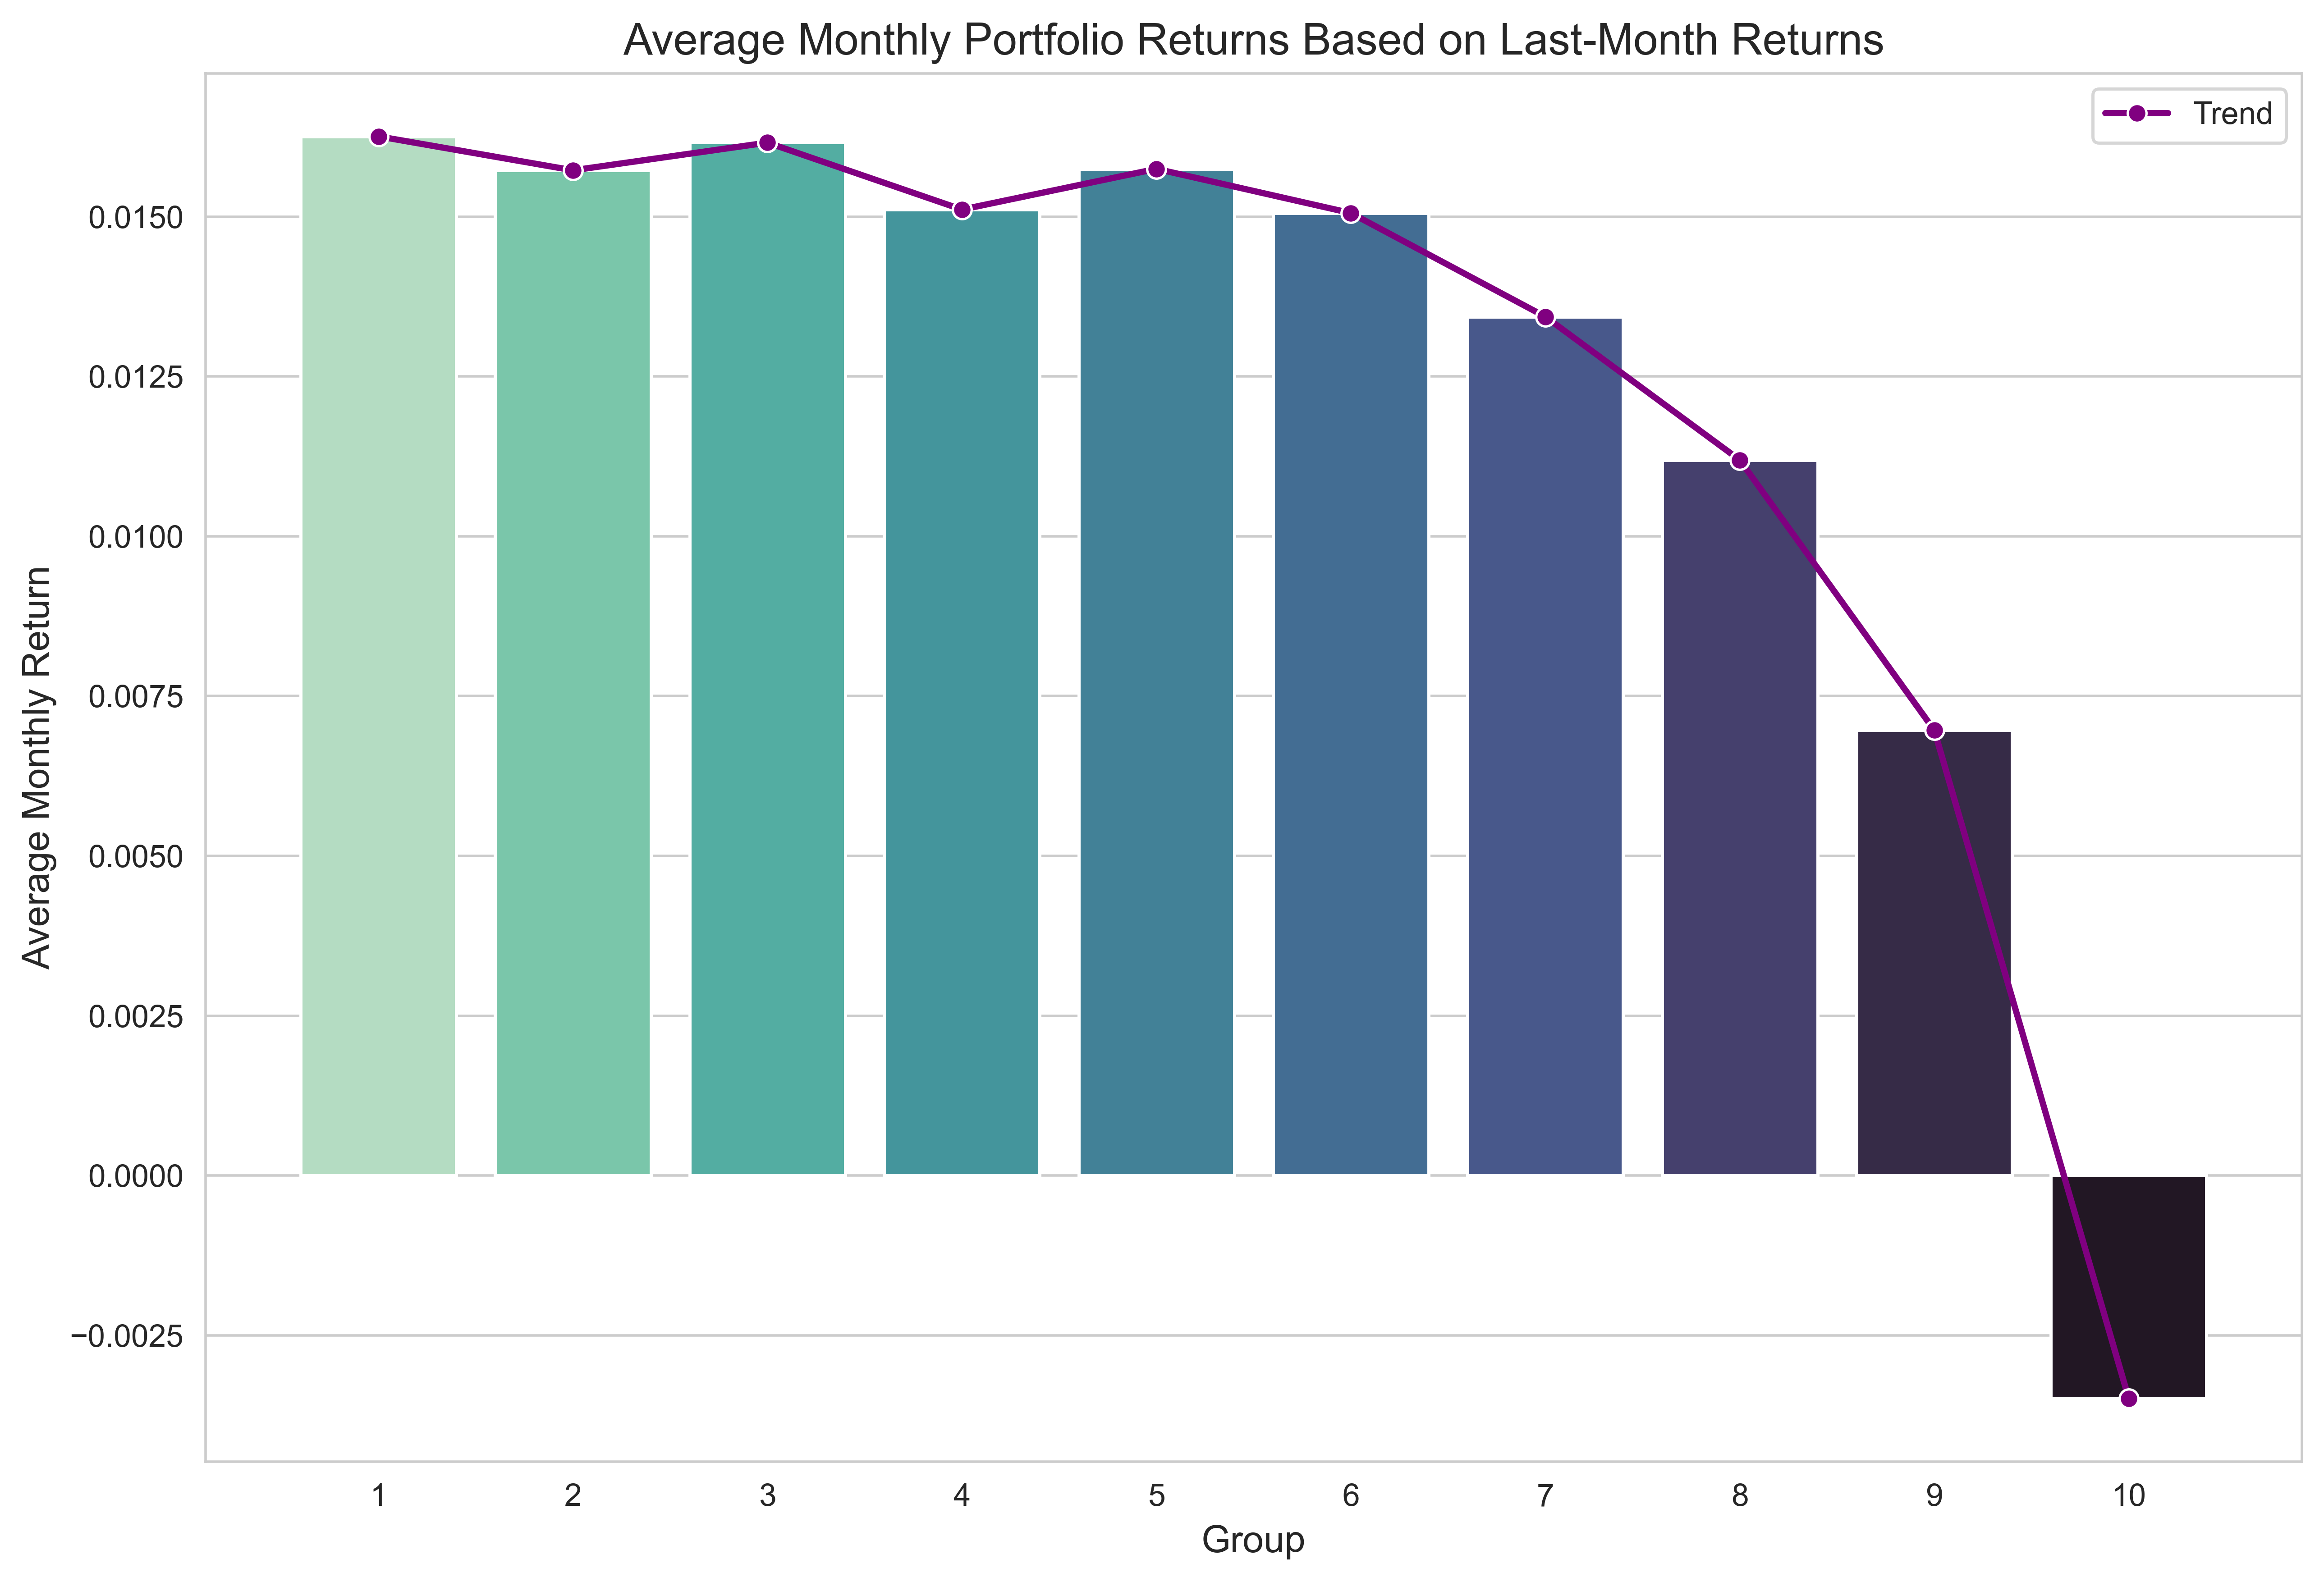

In [11]:
mean_returns = melted.groupby(['Group'])['Monthly_Return'].mean()
plt.figure(figsize=(12, 8), dpi = 500)
palette = sns.color_palette("mako_r", 10)
sns.set_style("whitegrid")
sns.set_palette(palette)
sns.barplot(x = mean_returns.index, y = mean_returns.values)
sns.lineplot(x=mean_returns.index - 1, y=mean_returns.values, color = 'purple', linewidth = 2, marker = 'o', label='Trend')

plt.xlabel('Group', fontsize = 12)
plt.ylabel('Average Monthly Return', fontsize = 12)
plt.title('Average Monthly Portfolio Returns Based on Last-Month Returns', fontsize = 14)
plt.show()

#### 1-2-2. Plot ten time-series for cumulative portfolio returns

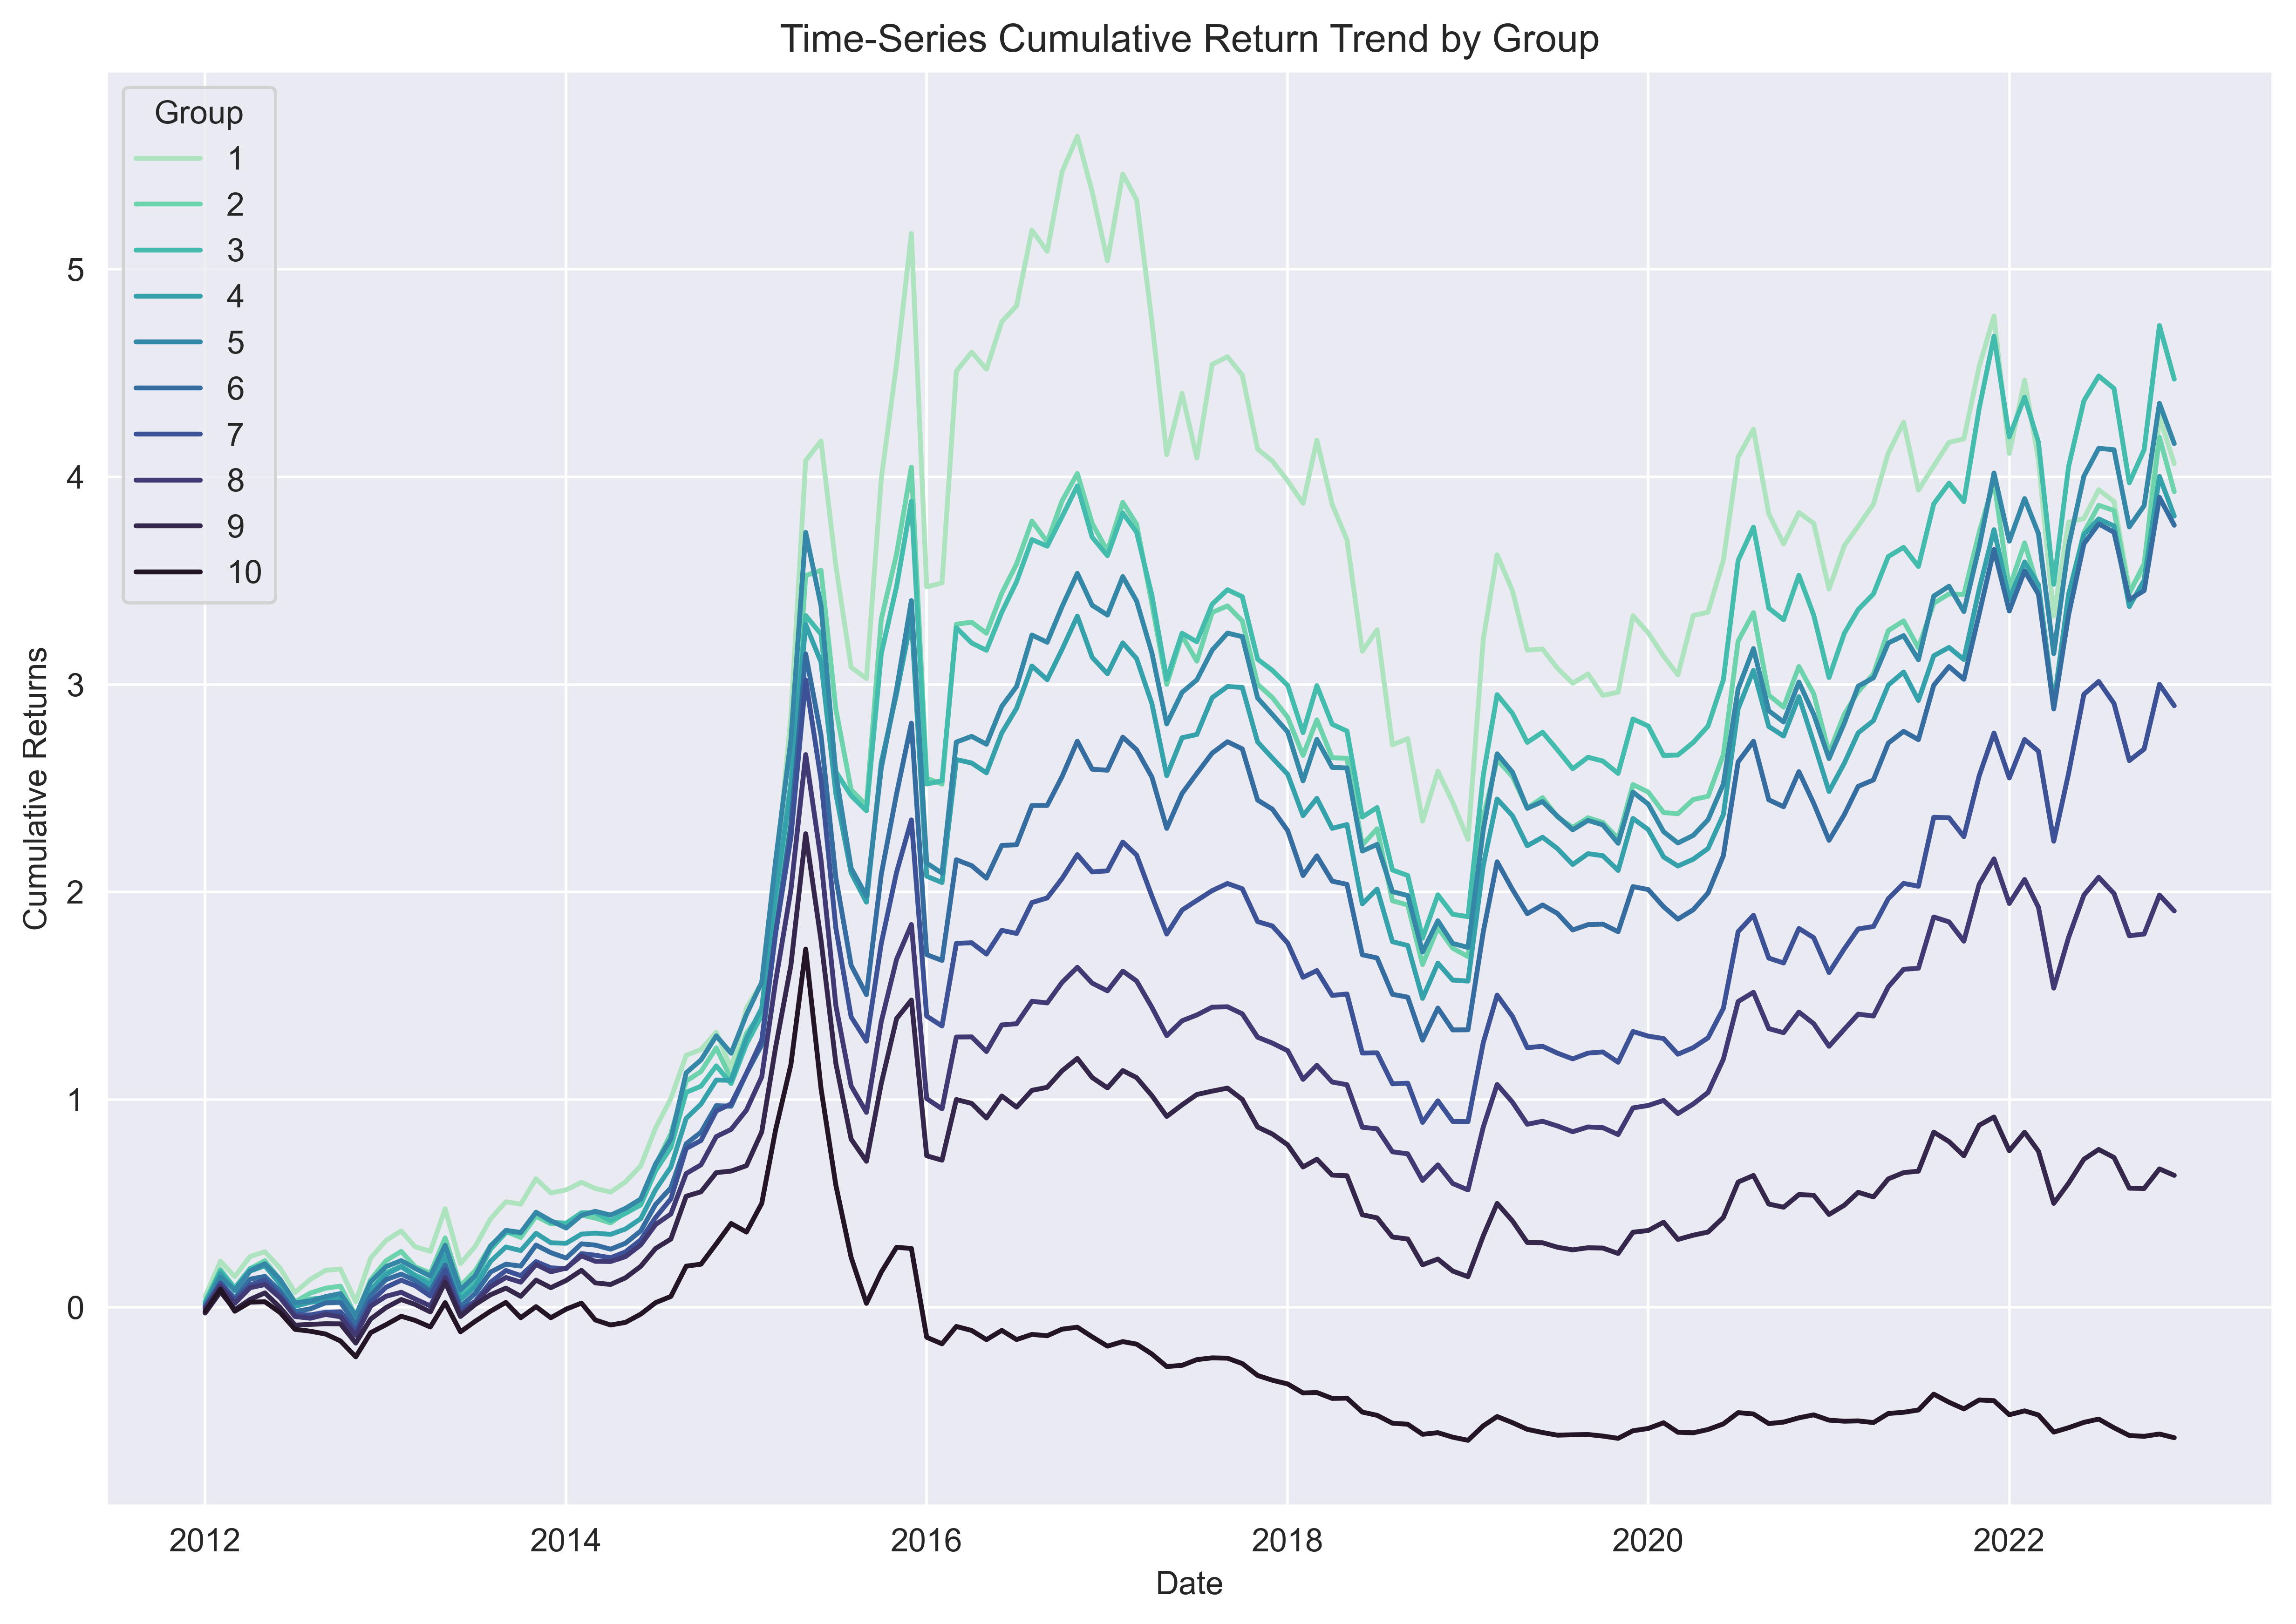

In [12]:
plt.figure(figsize=(12, 8), dpi = 500)
melted['Date'] = melted['Date'].dt.to_timestamp()
palette = sns.color_palette("mako_r", 10)
sns.set_style("darkgrid")
sns.lineplot(x = 'Date', y = 'Cum Return', hue = 'Group', data = melted, palette = palette)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Time-Series Cumulative Return Trend by Group')
plt.show()

### 1-3. Problem 1-3: Discuss my findings

**Finding 1**
- ***Observation***: In the bar chart, there is a crystal-clear relationship between group and average monthly return (The purple line trend). To be specific, for the portfolio / group with higher last month return, it has lower average monthly return. 
- ***Analysis***: 
    - Asset Pricing Perspective: Explain with APT, higher the last month return, higher the beta value of different factors. For most of the stocks, betas of factors (Market Premium, Book-Market, Size etc) would change after one month, so the return will more likely to be lower in a month. So, for the portfolio with higher last month return, it has lower average monthly return. 
    - Corporate Finance Perspective: Required rate of return of stocks are cost of equity. Cost of equity is affected by investor sentiment and dividend policy, these two factors would change from month to month generally, which means cost of equity is relatively unstable after one month. So, for the portfolio with higher last month return, it has lower average monthly return. 


**Finding 2**
- ***Observation***: In the bar chart, the trend is not obvious for the first three groups.
- ***Analysis***: 
    - The last month returns for the first three groups are small, and the difference between these groups is relatively small, so the average monthly returns of these groups are similar.

**Finding 3**
- ***Observation***: Before 2022, the trend is that for the portfolio / group with higher last month return, it has lower cumulative return. 
- ***Analysis***: 
    - Asset Pricing Perspective: Explain with APT, higher the last month return, higher the beta value of different factors. For most of the stocks, betas of factors (Market Premium, Book-Market, Size etc) would change after one month, so the return will more likely to be lower in a month. So, for the portfolio with higher last month return, it has lower cumulative return. 
    - Corporate Finance Perspective: Required rate of return of stocks are cost of equity. Cost of equity is affected by investor sentiment and dividend policy, these two factors would change from month to month generally, which means cost of equity is relatively unstable after one month. So, for the portfolio with higher last month return, it has lower cumulative return. 

**Finding 4**
- ***Observation***: Starting from 2022, cumulative returns for the first five groups converge together. 
- ***Analysis***: 
    - My personal guess is that it may due to the development of quantitative finance. Quantitative traders may depend on such factor (Last month return) to make the alpha of this strategy close to 0. The outcome is that the cumulative returns for the first five groups converge together.

## Problem 2

### 2-1. Problem 2-1: Construct ten portfolios

### 2-1-1. Construct records of Return and last-quarter ROE

#### 2-1-1-1. Compute quarterly returns based on monthly returns

In [13]:
# Convert the variable type.
table_one['Date'] = pd.to_datetime(table_one['Date']).dt.to_period('Q')

# Compute the quarterly record.
table_one['temp_Return'] = table_one['Monthly_Return'] + 1
table_one['Quarterly_Return'] = table_one.groupby(['Stock_Code', 'Date'])['temp_Return'].cumprod() - 1

# Combine the quarterly record into a new dataframe.
df_QReturn = table_one.groupby(['Stock_Code', 'Date']).aggregate({'Quarterly_Return': 'last'})
df_QReturn = df_QReturn.reset_index()
df_QReturn.head()

,Stock_Code,Date,Quarterly_Return
0,1,2011Q4,0.005158
1,1,2012Q1,0.007697
2,1,2012Q2,-0.035009
3,1,2012Q3,-0.133905
4,1,2012Q4,0.229191


#### 2-1-1-2. Merge two dataframes

In [14]:
table_two['Date'] = pd.to_datetime(table_two['Date']).dt.to_period('Q')
df_2 = pd.merge(df_QReturn, table_two, on=['Stock_Code', 'Date'], how='left')
df_2.head()

,Stock_Code,Date,Quarterly_Return,ROE
0,1,2011Q4,0.005158,0.191392
1,1,2012Q1,0.007697,0.199879
2,1,2012Q2,-0.035009,0.212389
3,1,2012Q3,-0.133905,0.169366
4,1,2012Q4,0.229191,0.168696


In [15]:
df_2['last_ROE'] = df_2.groupby(["Stock_Code"])['ROE'].shift()
df_2 = df_2.loc[(df_2['Date'] >= '2012-01') & (df_2['Date'] <= '2022-12')]
df_2 = df_2.loc[:,["Stock_Code", "Date", "Quarterly_Return", "last_ROE"]]
df_2.head()

,Stock_Code,Date,Quarterly_Return,last_ROE
1,1,2012Q1,0.007697,0.191392
2,1,2012Q2,-0.035009,0.199879
3,1,2012Q3,-0.133905,0.212389
4,1,2012Q4,0.229191,0.169366
5,1,2013Q1,0.255931,0.168696


In [16]:
df_2.describe()

,Stock_Code,Quarterly_Return,last_ROE
count,113799.000000,113271.000000,109180.000000
mean,301475.345126,0.033739,0.037285
std,301822.440084,0.270412,1.567324
min,1.000000,-0.943182,-263.818271
25%,2193.000000,-0.112188,0.024827
50%,3008.000000,-0.009395,0.070879
75%,600773.000000,0.124183,0.123163
max,873527.000000,13.008922,228.695791


### 2-1-2. Construct monthly portfolios

In [17]:
portfolios_curr = pd.DataFrame()

for quarterYear in pd.period_range('2012-01', '2022-12', freq = 'Q'):
    data_currQY = df_2.loc[df_2['Date'] == quarterYear]

    data_currQY = data_currQY.sort_values('last_ROE')
    
    data_currQY['group'] = pd.qcut(data_currQY['last_ROE'], 10, labels = False)
    
    group_curr_returns = data_currQY.groupby('group')['Quarterly_Return'].mean()
    
    portfolios_curr[quarterYear] = group_curr_returns

portfolios_curr = portfolios_curr.T

melted = pd.melt(portfolios_curr.reset_index(), id_vars=['index'], value_vars = list(portfolios_curr.columns), var_name = 'group', value_name = 'Quarterly_Return')
melted.columns = ['Date', 'Group', 'Quarterly_Return']
melted = melted.sort_values(['Group','Date'])
melted["Group"] = melted["Group"] + 1
melted['Group'] = melted['Group'].astype(int)
melted["temp"] = melted["Quarterly_Return"] + 1
melted["Cum Return"] = melted.groupby("Group")["temp"].cumprod() - 1

In [18]:
melted.head()

,Date,Group,Quarterly_Return,temp,Cum Return
0,2012Q1,1,0.074787,1.074787,0.074787
1,2012Q2,1,-0.017288,0.982712,0.056206
2,2012Q3,1,-0.090397,0.909603,-0.039272
3,2012Q4,1,0.059508,1.059508,0.017899
4,2013Q1,1,0.027911,1.027911,0.046310


### 2-2. Problem 2-2: Do plotting from 2012Q1 to 2022Q4

### 2-2-1. Plot a bar chart for average quarterly portfolios returns

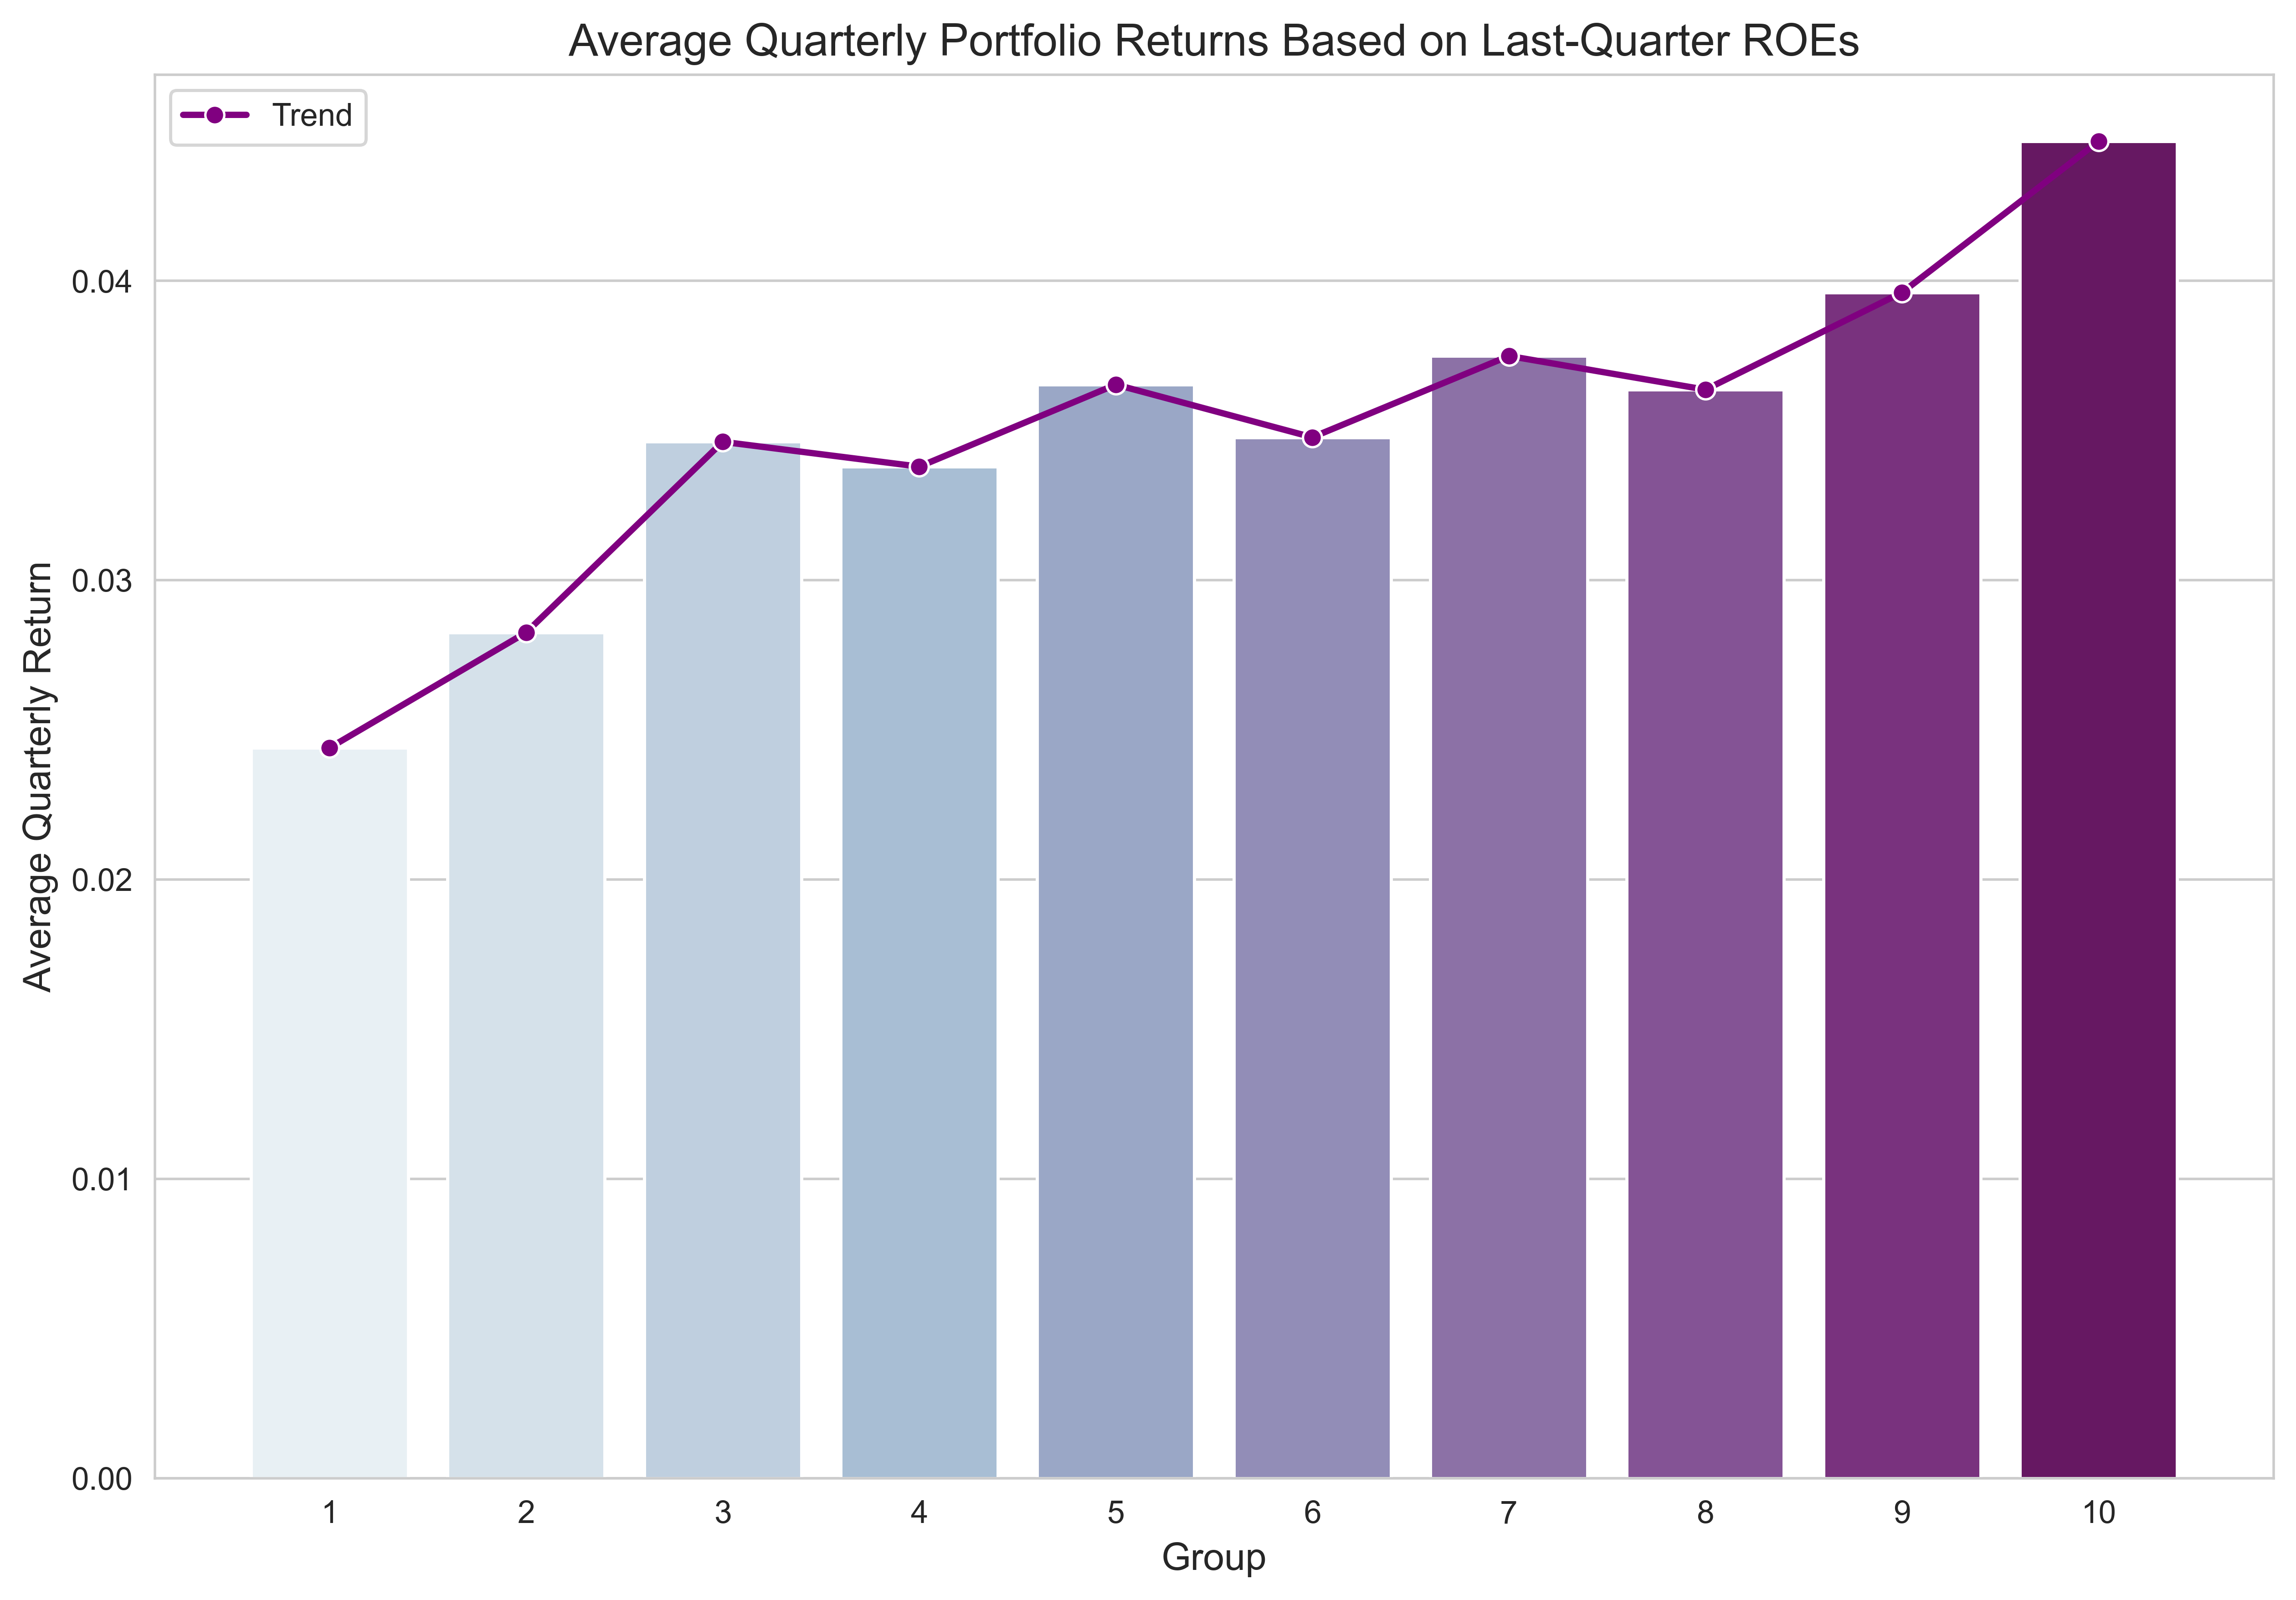

In [19]:
mean_returns = melted.groupby(['Group'])['Quarterly_Return'].mean()
plt.figure(figsize=(12, 8), dpi = 500)
palette = sns.color_palette("BuPu", 10)
sns.set_style("whitegrid")
sns.set_palette(palette)
sns.barplot(x = mean_returns.index, y = mean_returns.values)
sns.lineplot(x=mean_returns.index - 1, y=mean_returns.values, color = 'purple', linewidth = 2, marker = 'o', label='Trend')

plt.xlabel('Group', fontsize = 12)
plt.ylabel('Average Quarterly Return', fontsize = 12)
plt.title('Average Quarterly Portfolio Returns Based on Last-Quarter ROEs', fontsize = 14)
plt.show()

### 2-2-2. Plot ten time-series for cumulative portfolio returns

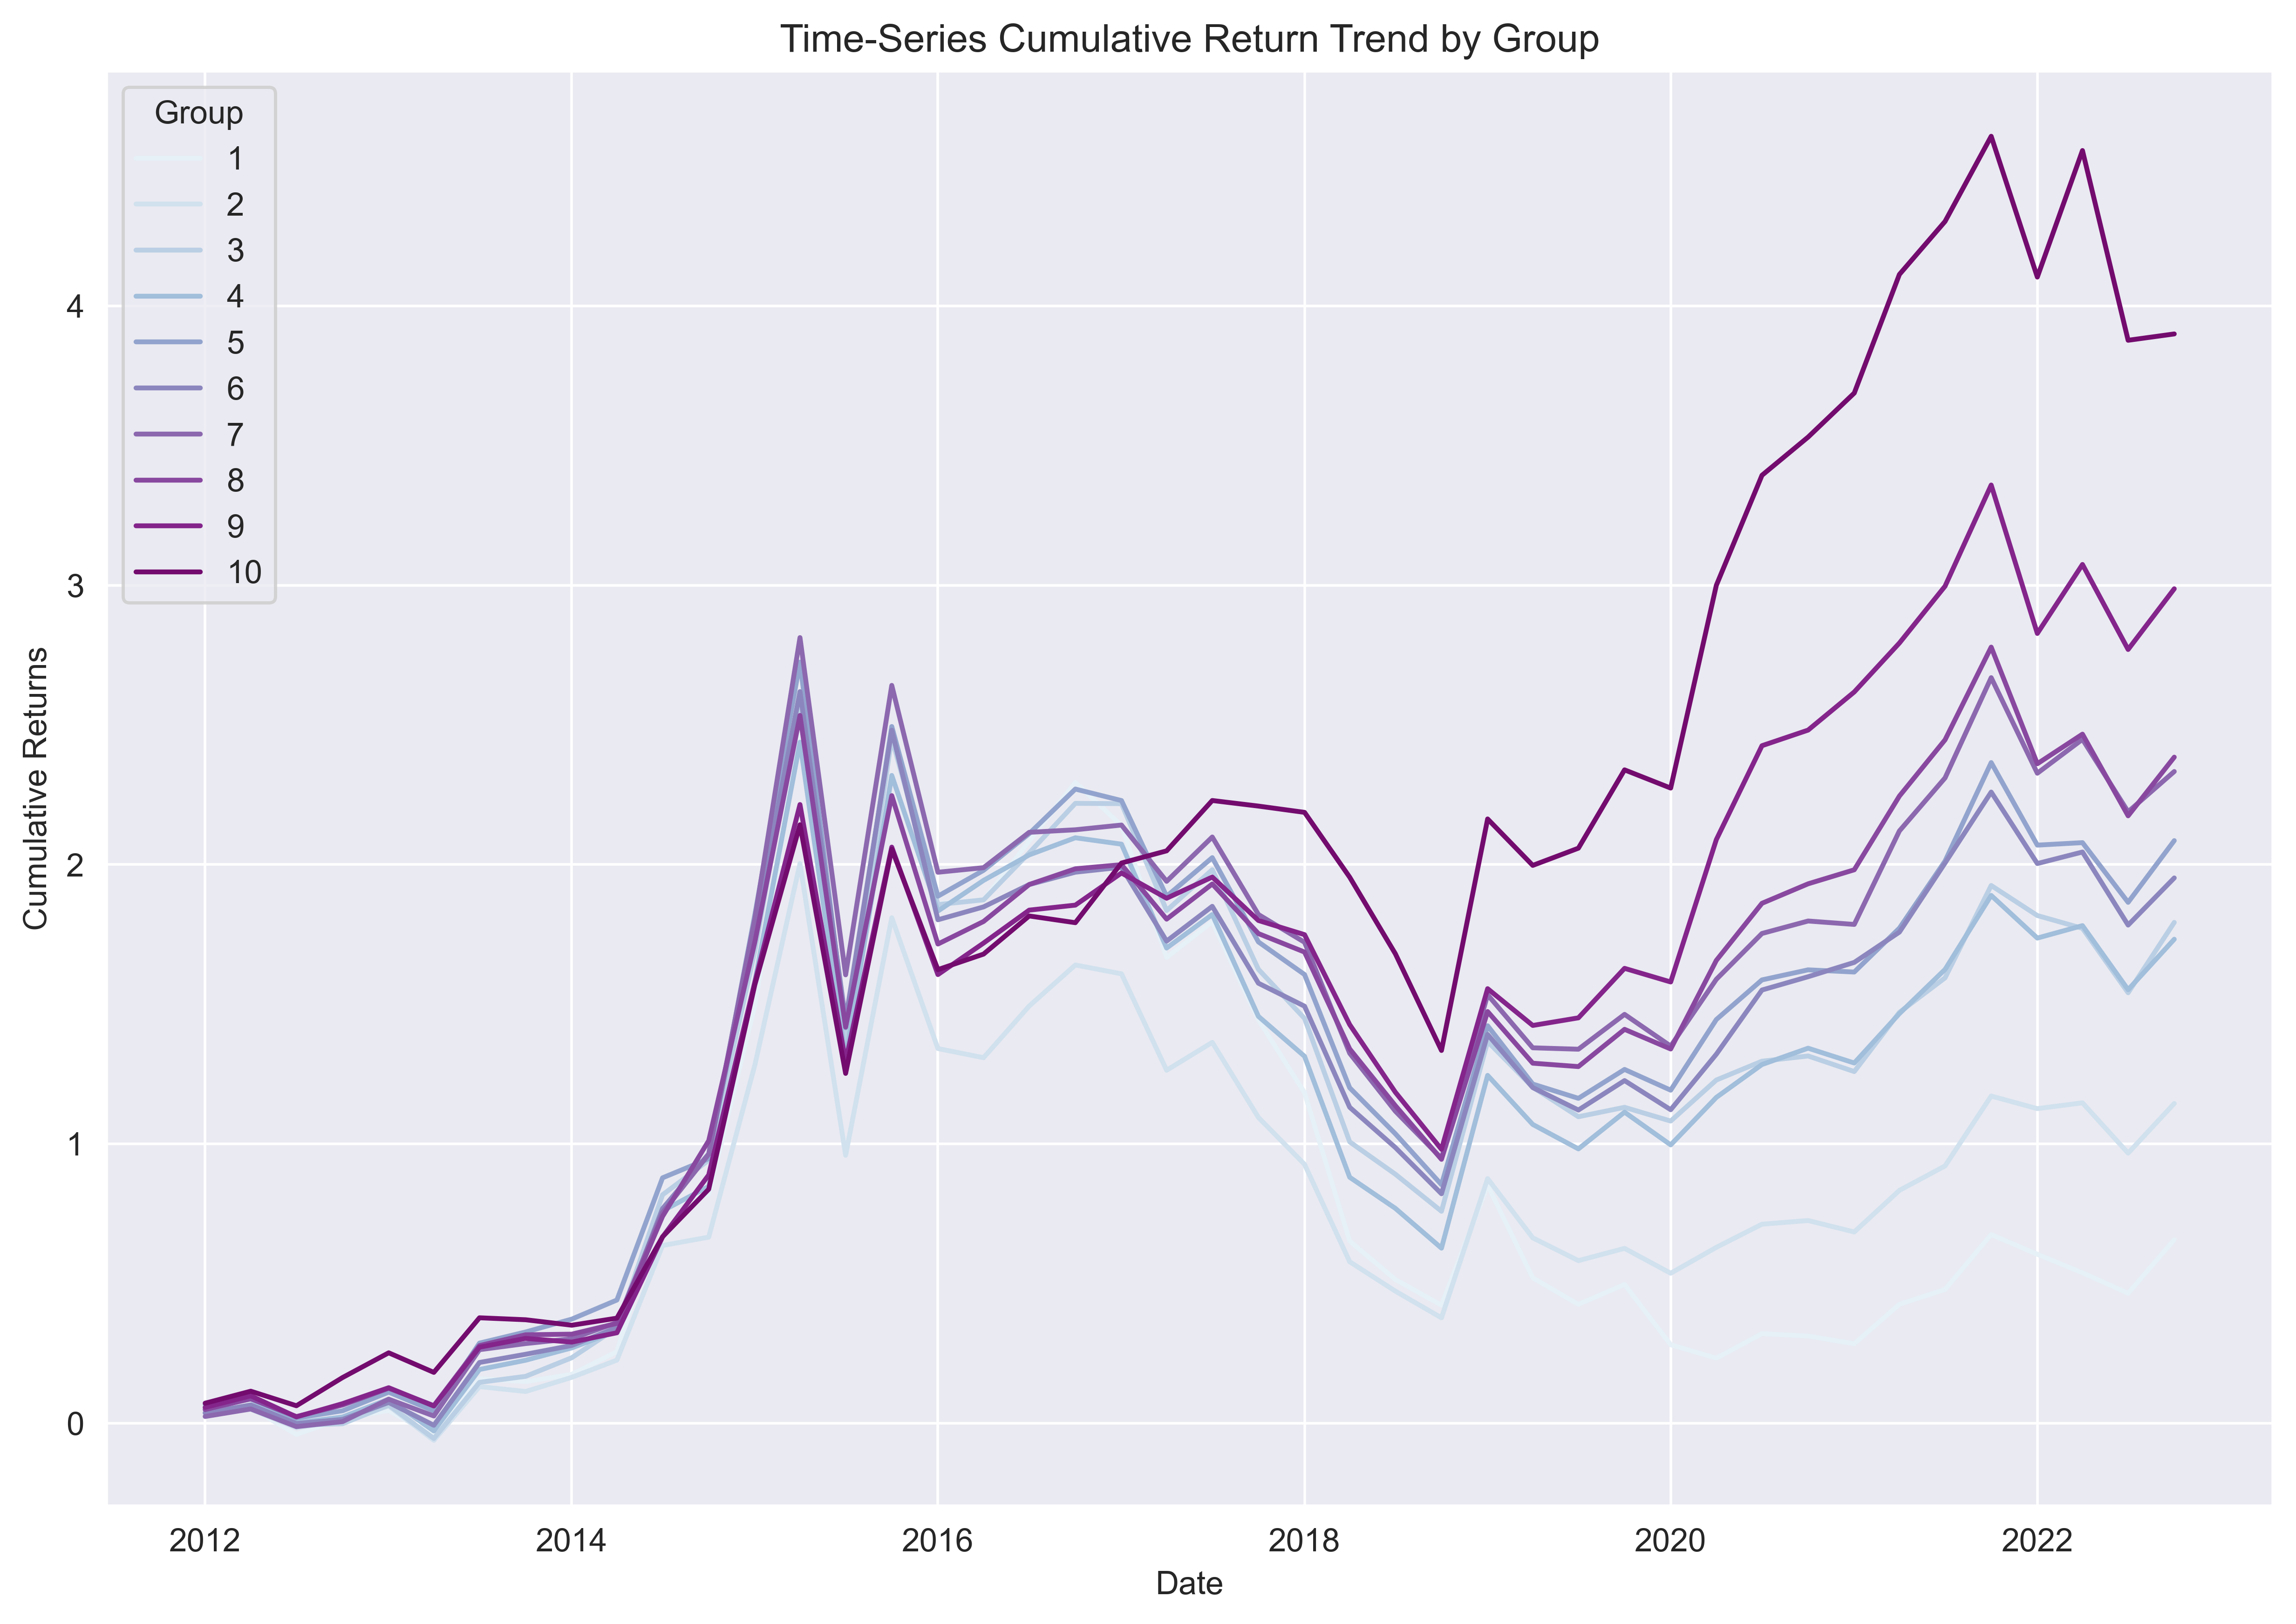

In [20]:
melted['Date'] = melted['Date'].dt.to_timestamp()
plt.figure(figsize=(12, 8), dpi = 500)
palette = sns.color_palette("BuPu", 10)
sns.set_style("darkgrid")
sns.lineplot(x = 'Date', y = 'Cum Return', hue = 'Group', data = melted, palette = palette)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Time-Series Cumulative Return Trend by Group')
plt.show()

### 2-3. Problem 2-3: Discuss my findings

**Finding 1**
- ***Observation***: In the bar chart, there is a crystal-clear relationship between group and average quarterly return (The purple line trend). To be specific, for the portfolio / group with higher last quarter ROE, it has higher average quarterly return. 
- ***Analysis***: 
    - Higher ROE means higher earnings per equity, means higher profitability of the firm, means a more substantial positive cash flow in the future, which is more attractive to investors. Then the demand of the stock is higher, the stock price would be pushed up, then the stock return increases.

**Finding 2**
- ***Observation***: From 2012 to 2018, the trends of all the portfolios are similar and syncronized. While starting from 2018, performance of different groups diverge, to be specific, for the group with higher last quarter ROE, it has higher cumulative return. 
- ***Analysis***: 
    - The China Securities Regulatory Commission encourages companies to list, but lacks a sound system for delisting. 
    - Before 2018 (relative short term), most of listed firms behave relatively normarlly (Normal ROE), stock returns of listed companies with different earnings performance (different ROE) are similar.
    - After 2018 (relative long term), defects of delisting system are exposed， the stock returns of listed companies with different earnings performance (different ROE) are clearly differentiated.